# **British Airways Reviews Analysis**

## **1. Importing Required Libraries**

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## **2. Setting Headers for Web Scraping**

In [4]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
}

## **3. Scraping British Airways Reviews**

In [7]:
reviews, authors, seats, stars, dates = [], [], [], [], []
num_pages = 393  

for i in range(1, num_pages + 1):
    url = f"https://www.airlinequality.com/airline-reviews/british-airways/page/{i}/"
    print(f"Fetching page {i} of {num_pages}")

    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch page {i}")
        continue

    soup = BeautifulSoup(response.text, "html.parser")

    review_elements = soup.find_all("div", class_="text_content")
    for review in review_elements:
        reviews.append(review.get_text(strip=True))
    if len(reviews) < len(authors):
        reviews.append(np.nan)

    author_elements = soup.find_all("span", attrs={"itemprop": "name"})
    for author in author_elements:
        authors.append(author.get_text(strip=True))
    if len(authors) < len(reviews):
        authors.append(np.nan)

    seat_rows = soup.find_all("tr")
    for row in seat_rows:
        seat_type_td = row.find("td", class_="review-rating-header cabin_flown")
        if seat_type_td:
            seat_value_td = seat_type_td.find_next_sibling("td")
            seats.append(seat_value_td.get_text(strip=True) if seat_value_td else np.nan)
    if len(seats) < len(reviews):
        seats.append(np.nan)

    star_elements = soup.find_all("span", attrs={"itemprop": "ratingValue"})
    for star_element in star_elements:
        stars.append(star_element.get_text(strip=True))
    if len(stars) < len(reviews):
        stars.append(np.nan)

    date_elements = soup.find_all("time")
    for date_element in date_elements:
        dates.append(date_element.get_text(strip=True))
    if len(dates) < len(reviews):
        dates.append(np.nan)

Fetching page 1 of 393
Fetching page 2 of 393
Fetching page 3 of 393
Fetching page 4 of 393
Fetching page 5 of 393
Fetching page 6 of 393
Fetching page 7 of 393
Fetching page 8 of 393
Fetching page 9 of 393
Fetching page 10 of 393
Fetching page 11 of 393
Fetching page 12 of 393
Fetching page 13 of 393
Fetching page 14 of 393
Fetching page 15 of 393
Fetching page 16 of 393
Fetching page 17 of 393
Fetching page 18 of 393
Fetching page 19 of 393
Fetching page 20 of 393
Fetching page 21 of 393
Fetching page 22 of 393
Fetching page 23 of 393
Fetching page 24 of 393
Fetching page 25 of 393
Fetching page 26 of 393
Fetching page 27 of 393
Fetching page 28 of 393
Fetching page 29 of 393
Fetching page 30 of 393
Fetching page 31 of 393
Fetching page 32 of 393
Fetching page 33 of 393
Fetching page 34 of 393
Fetching page 35 of 393
Fetching page 36 of 393
Fetching page 37 of 393
Fetching page 38 of 393
Fetching page 39 of 393
Fetching page 40 of 393
Fetching page 41 of 393
Fetching page 42 of 393
F

## **4. Creating and Cleaning DataFrame**

In [32]:
min_length = min(len(reviews), len(authors), len(seats), len(stars), len(dates))
df_reviews = pd.DataFrame({
    "Reviewer": authors[:min_length],
    "Date": dates[:min_length],
    "Review": reviews[:min_length],
    "Seat Type": seats[:min_length],
    "Star Rating": stars[:min_length]
})

## **5. Data Preprocessing**

### **Converting Date Format**

In [33]:
def rm(date_str):
    return re.sub(r'(\d+)(st|nd|rd|th)', r'\1', date_str)

df_reviews['Date'] = df_reviews['Date'].apply(rm)
df_reviews['Date'] = pd.to_datetime(df_reviews['Date'])

### **Cleaning Review Column**

In [34]:
df_reviews['isVerified'] = df_reviews['Review'].str.startswith('✅')

df_reviews['Review'] = df_reviews['Review'].apply(lambda x: x.lstrip('✅Trip Verified').strip() if x.startswith('✅') else x)
df_reviews['Review'] = df_reviews['Review'].apply(lambda x: x.lstrip('Not Verified').strip() if x.startswith('Not Verified') else x)

## **6. Sentiment Analysis**

In [35]:
df_reviews['Star Rating'] = df_reviews['Star Rating'].astype(int)
df_reviews['Sentiment'] = np.where(df_reviews['Star Rating'] > 5, 'Positive', 
                                   np.where(df_reviews['Star Rating'] < 5, 'Negative', 'Neutral'))

## **7. Data Visualization**

### **Star Rating Distribution**

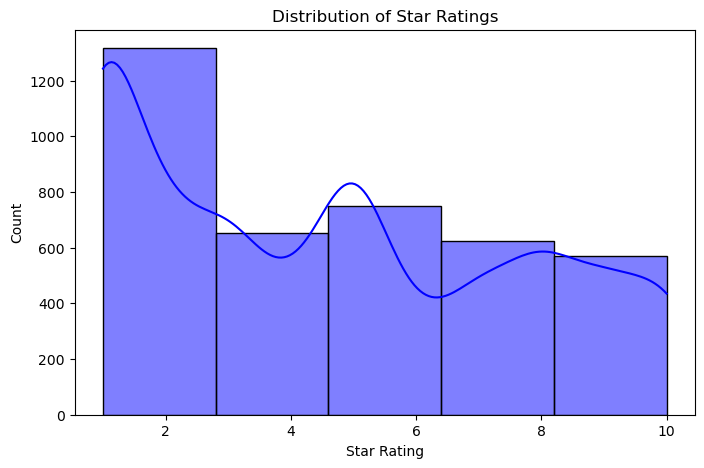

In [36]:
plt.figure(figsize=(8, 5))
sns.histplot(df_reviews['Star Rating'], bins=5, kde=True, color='blue')
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.title("Distribution of Star Ratings")
plt.show()

### **Sentiment Distribution**

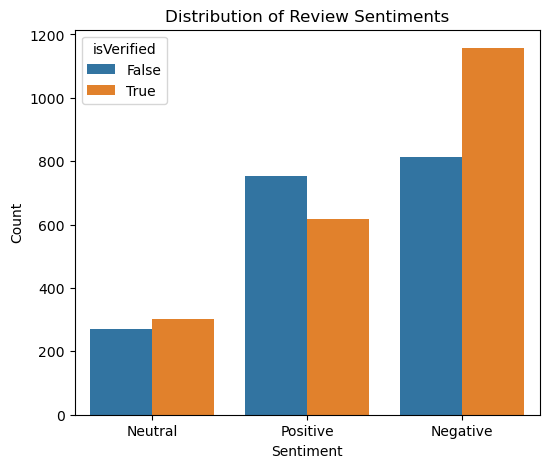

In [37]:
plt.figure(figsize=(6, 5))
sns.countplot(x='Sentiment', data=df_reviews, hue='isVerified')
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Review Sentiments")
plt.show()

### **Verified vs Non-Verified Reviews**

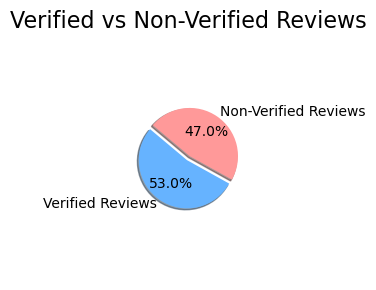

In [38]:
verified_total = df_reviews['isVerified'].sum()
non_verified_total = (~df_reviews['isVerified']).sum()

labels = ['Verified Reviews', 'Non-Verified Reviews']
sizes = [verified_total, non_verified_total]
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0)

plt.figure(figsize=(3, 3))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Verified vs Non-Verified Reviews", fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()

### **Star Rating Trends Over Time**

<Figure size 1000x600 with 0 Axes>

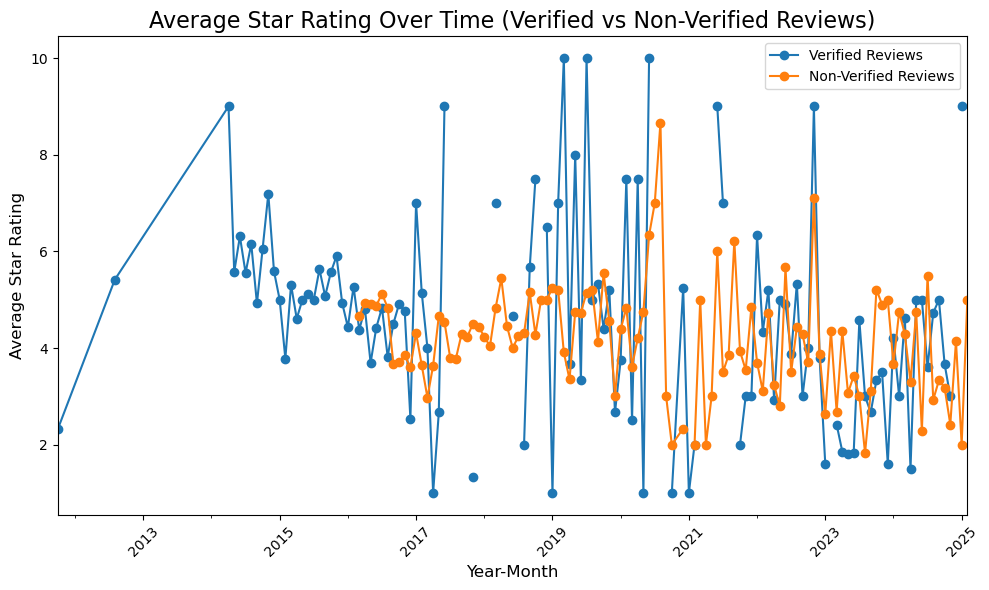

In [39]:
df_reviews['Year-Month'] = df_reviews['Date'].dt.to_period('M')
avg_star_rating = df_reviews.groupby(['Year-Month', 'isVerified'])['Star Rating'].mean().unstack()

plt.figure(figsize=(10, 6))
avg_star_rating.plot(kind='line', marker='o', figsize=(10, 6))
plt.title("Average Star Rating Over Time (Verified vs Non-Verified Reviews)", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Average Star Rating", fontsize=12)
plt.xticks(rotation=45)
plt.legend(['Verified Reviews', 'Non-Verified Reviews'])
plt.tight_layout()
plt.show()

### **Seat Type vs Review Count**

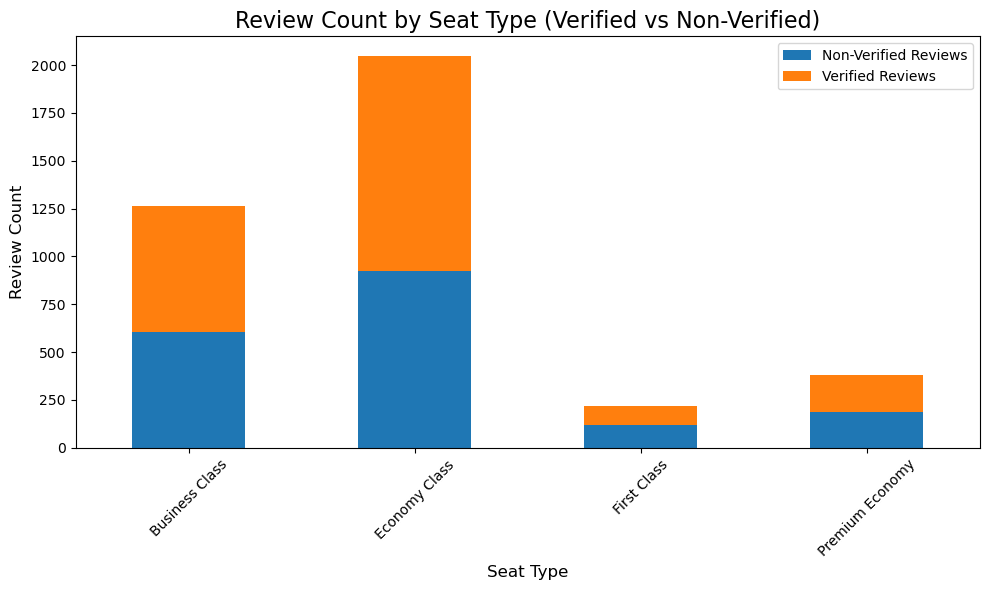

In [40]:
seat_review_count = df_reviews.groupby(['Seat Type', 'isVerified']).size().unstack(fill_value=0)
seat_review_count.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Review Count by Seat Type (Verified vs Non-Verified)", fontsize=16)
plt.xlabel("Seat Type", fontsize=12)
plt.ylabel("Review Count", fontsize=12)
plt.xticks(rotation=45)
plt.legend(['Non-Verified Reviews', 'Verified Reviews'], loc='upper right')
plt.tight_layout()
plt.show()

### **Word Clouds for Sentiments**

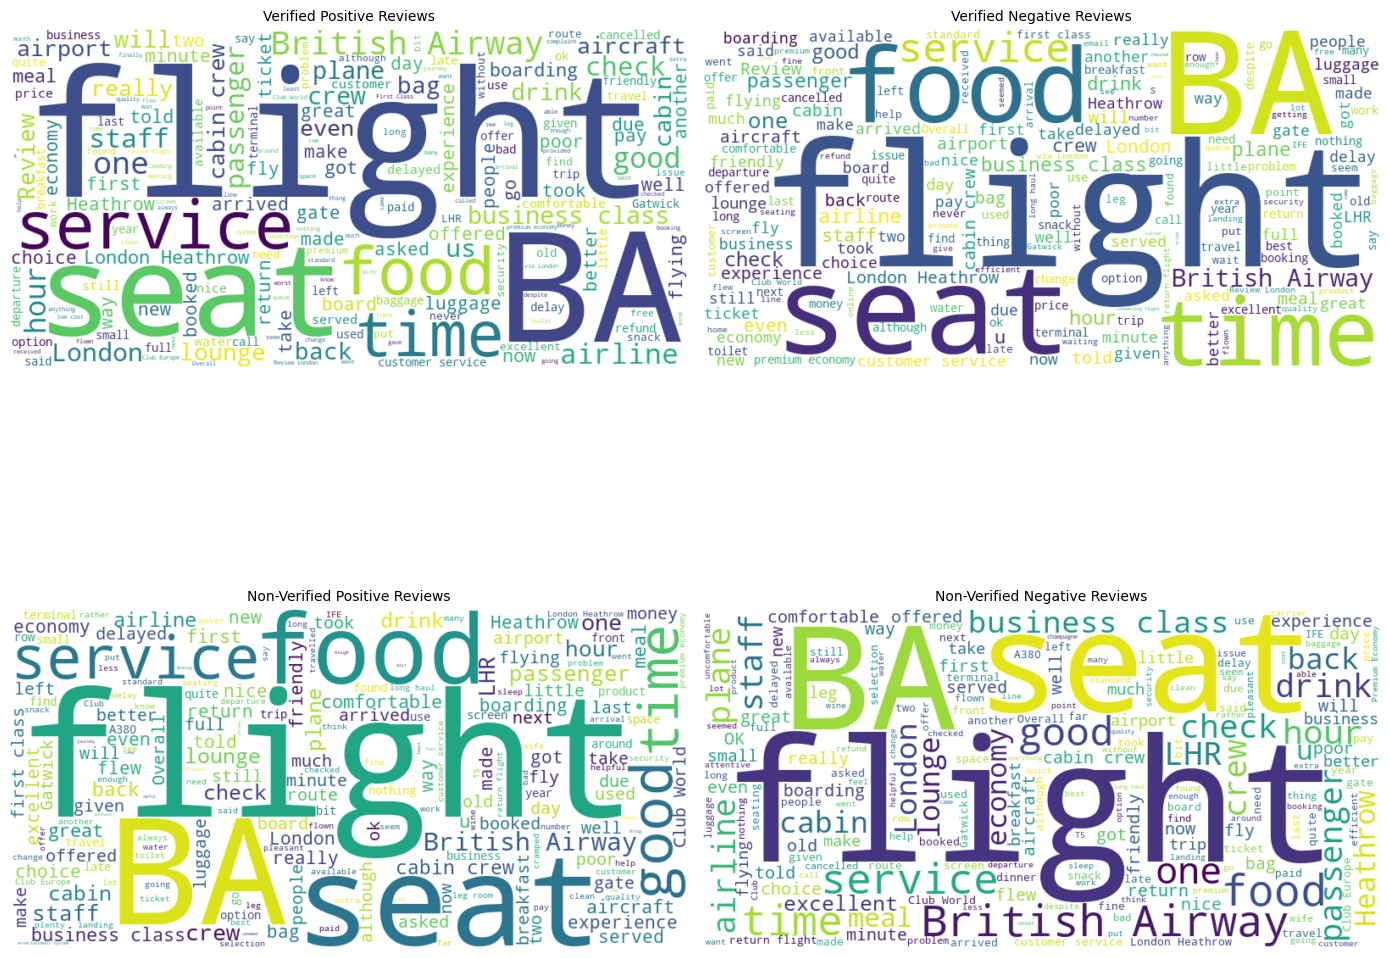

In [42]:
verified_reviews = df_reviews[df_reviews['isVerified'] == True]
non_verified_reviews = df_reviews[df_reviews['isVerified'] == False]

verified_positive_reviews = verified_reviews[verified_reviews['Sentiment'] == 'Positive']['Review']
verified_negative_reviews = verified_reviews[verified_reviews['Sentiment'] == 'Negative']['Review']
non_verified_positive_reviews = non_verified_reviews[non_verified_reviews['Sentiment'] == 'Positive']['Review']
non_verified_negative_reviews = non_verified_reviews[non_verified_reviews['Sentiment'] == 'Negative']['Review']

verified_positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(verified_positive_reviews))
verified_negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(verified_negative_reviews))
non_verified_positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_verified_positive_reviews))
non_verified_negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_verified_negative_reviews))

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

axes[0, 0].imshow(verified_positive_wordcloud, interpolation='bilinear')
axes[0, 0].axis('off')
axes[0, 0].set_title("Verified Positive Reviews", fontsize=10)

axes[0, 1].imshow(verified_negative_wordcloud, interpolation='bilinear')
axes[0, 1].axis('off')
axes[0, 1].set_title("Verified Negative Reviews", fontsize=10)

axes[1, 0].imshow(non_verified_positive_wordcloud, interpolation='bilinear')
axes[1, 0].axis('off')
axes[1, 0].set_title("Non-Verified Positive Reviews", fontsize=10)

axes[1, 1].imshow(non_verified_negative_wordcloud, interpolation='bilinear')
axes[1, 1].axis('off')
axes[1, 1].set_title("Non-Verified Negative Reviews", fontsize=10)

plt.tight_layout()
plt.show()

## Boxplot of Star Ratings by Seat Type and Verified Status

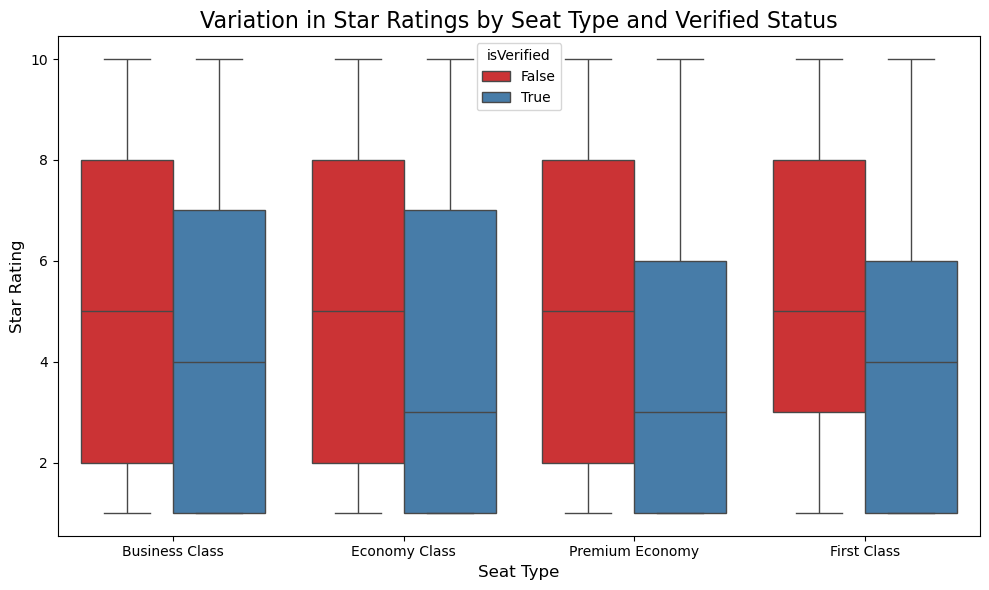

In [44]:
df_reviews['Stars'] = df_reviews['Star Rating'].astype(float)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Seat Type', y='Stars', hue='isVerified', data=df_reviews, palette='Set1')

plt.title('Variation in Star Ratings by Seat Type and Verified Status', fontsize=16)
plt.xlabel('Seat Type', fontsize=12)
plt.ylabel('Star Rating', fontsize=12)

plt.tight_layout()
plt.show()


## Heatmap of Star Ratings by Seat Type

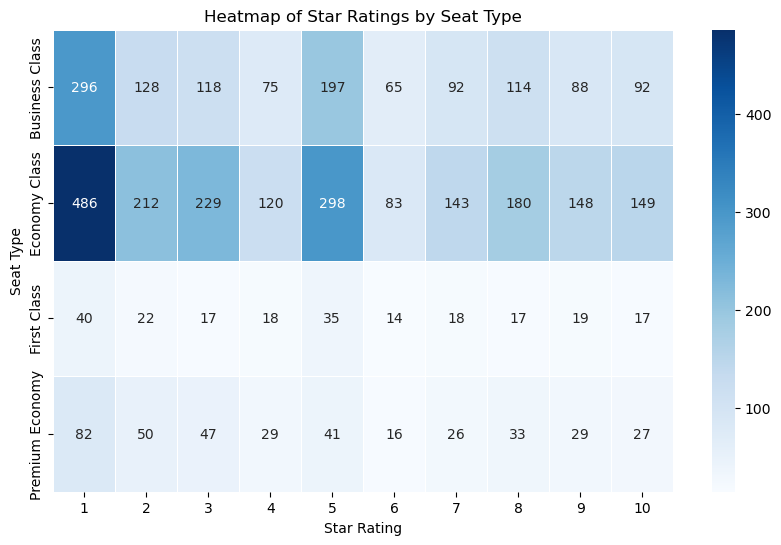

In [45]:
heatmap_data = pd.crosstab(df_reviews['Seat Type'], df_reviews['Star Rating'])

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", fmt="d", linewidths=0.5)

plt.title("Heatmap of Star Ratings by Seat Type")
plt.xlabel("Star Rating")
plt.ylabel("Seat Type")

plt.show()

## Conclusion

This analysis of **British Airways customer reviews** offers valuable insights into passenger sentiment, seat types, and the overall customer experience. By scraping data from **AirlineQuality.com**, I have explored various trends and patterns from a significant dataset of **verified** and **non-verified reviews**.

### Key Findings:
- **Verified vs Non-Verified Reviews**: A large majority of reviews (**87.8%**) are **verified**, reinforcing the reliability of this analysis. However, **12.2%** of reviews are **non-verified**, and these tend to have **higher ratings** compared to verified ones.
- **Seat Type Distribution**: **Economy class** receives the highest number of reviews, while **First class** receives the least. Interestingly, **premium customers**, who are more likely to leave **verified reviews**, tend to have stronger opinions—both positive and negative—shaping the overall **brand perception**.
- **Review Trends Over Time**: Over the past **12 years**, **verified star ratings** have shown high fluctuations, whereas **non-verified ratings** have remained relatively stable.
  
### Sentiment Insights:
- **Verified Negative Reviews**: Common concerns include **seat comfort**, **staff behavior**, **punctuality**, **luggage handling**, **food quality**, **delays**, and **overall service**.
- **Verified Positive Reviews**: Praise is often given to **punctuality**, **seat comfort**, **lounge experience**, **passenger behavior**, and **breakfast**, with significant positive feedback for **seats** and **services**.

### Visual Insights:
- The **heatmap** of star ratings across seat types highlighted the differences in sentiment between various seat classes, showcasing a stronger correlation between **premium seating** and **extreme reviews** (both positive and negative).
- The **boxplot** analysis revealed that **premium passengers** tend to leave more **verified reviews**, and these reviews show greater **variability** in ratings compared to economy class.

### Recommendations:
- British Airways should focus on improving **seat comfort**, **staff behavior**, and **food quality**—as these are frequently mentioned concerns in **negative reviews**.
- By enhancing the **overall customer experience**, particularly for **premium passengers**, the airline can continue to strengthen its reputation and increase **verified positive reviews**.
- **Non-verified reviews** tend to be more positive, so addressing the concerns in verified reviews could help improve the overall customer perception and trust in the service.

This analysis offers a **clear understanding** of customer feedback and can guide **future improvements** in service quality, customer engagement, and overall brand experience.
